In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install emoji py_vncorenlp
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [3]:
import os 
import shutil
import zipfile

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
tf.get_logger().setLevel('ERROR')

In [4]:
zip_path = "/content/drive/MyDrive/students_feedback_data.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
train_path = 'students_feedback_data/train.csv'
val_path = 'students_feedback_data/val.csv'

In [6]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

train_df.head()

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,positive,training_program
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,lecturer
2,đi học đầy đủ full điểm chuyên cần .,negative,training_program
3,chưa áp dụng công nghệ thông tin và các thiết ...,negative,lecturer
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,lecturer


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   14592 non-null  object
 1   sentiment  14592 non-null  object
 2   topic      14592 non-null  object
dtypes: object(3)
memory usage: 342.1+ KB


<Axes: xlabel='sentiment', ylabel='count'>

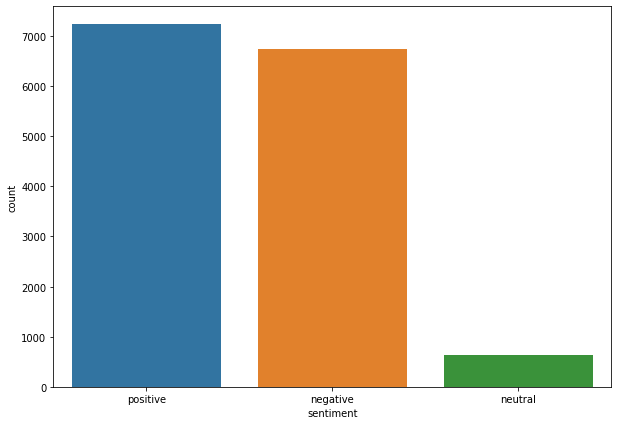

In [8]:
plt.figure(figsize=(10,7))
sns.countplot(x=train_df['sentiment'])

<Axes: xlabel='sentiment', ylabel='count'>

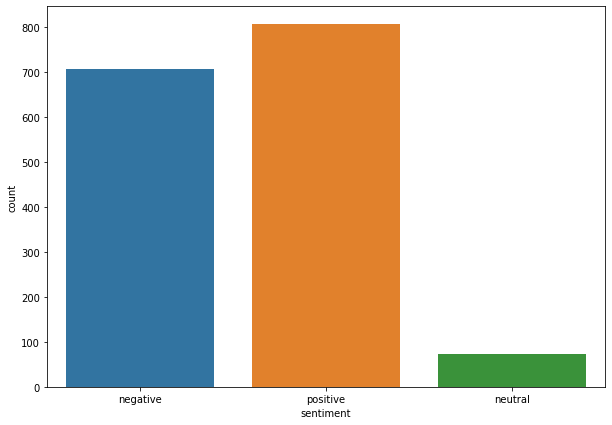

In [9]:
plt.figure(figsize=(10,7))
sns.countplot(x=val_df['sentiment'])

In [10]:
import py_vncorenlp
py_vncorenlp.download_model() 
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"])

In [11]:
import re
import string
import emoji

def preprocessing_text(text, word_segment=True):
  # Biến đổi về chữ thường
  text = text.lower()
  # Loại bỏ biểu tượng
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  # Loại bỏ các dấu câu
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  # Phân đoạn từ bằng py_vncorenlp
  if word_segment == False:
    return text
  text = rdrsegmenter.word_segment(text)

  return " ".join(text).strip()
preprocessing_text("chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .")

'chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy'

In [12]:
train_df['sentence'] = train_df['sentence'].apply(preprocessing_text)
val_df['sentence'] = val_df['sentence'].apply(preprocessing_text)

In [13]:
train_sentences = train_df['sentence'].to_list()
val_sentences = val_df['sentence'].to_list()

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["sentiment"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["sentiment"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["sentiment"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["sentiment"].to_numpy())

train_labels_encoded

array([2, 2, 0, ..., 2, 0, 1])

In [16]:
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(3, array(['negative', 'neutral', 'positive'], dtype=object))

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

#Model 0: Tạo mô hình cơ sở Tf-idf

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([0, 0, 2, ..., 0, 0, 0])

In [20]:
calculate_result(y_true=val_labels_encoded,
                 y_pred=model_0_preds)

{'accuracy': 0.8698673404927353,
 'precision': 0.8791305379670522,
 'recall': 0.8698673404927353,
 'f1-score': 0.8515601420208461}

# Sử dụng BERT

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(AUTOTUNE)

In [22]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Sentences: {text_batch[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Sentences: b'slide gi\xc3\xa1o_tr\xc3\xacnh \xc4\x91\xe1\xba\xa7y_\xc4\x91\xe1\xbb\xa7'
Label : [0. 0. 1.]
Sentences: b'nhi\xe1\xbb\x87t_t\xc3\xacnh gi\xe1\xba\xa3ng_d\xe1\xba\xa1y g\xe1\xba\xa7n_g\xc5\xa9i v\xe1\xbb\x9bi sinh_vi\xc3\xaan'
Label : [0. 0. 1.]
Sentences: b'\xc4\x91i h\xe1\xbb\x8dc \xc4\x91\xe1\xba\xa7y_\xc4\x91\xe1\xbb\xa7 full \xc4\x91i\xe1\xbb\x83m chuy\xc3\xaan_c\xe1\xba\xa7n'
Label : [1. 0. 0.]


In [23]:
tfhub_handle_preprocess = "https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2"
tfhub_handle_encoder = "https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1"

In [24]:
def build_classifier_model():
  text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [33]:
classifier_model = build_classifier_model()

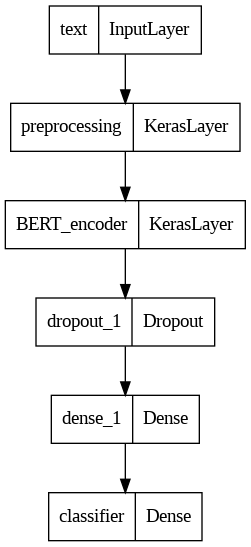

In [34]:
tf.keras.utils.plot_model(classifier_model)

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_stop(self, epoch, logs={}):
    if logs.get('accuracy') > 0.95:
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
on_epoch_stop = myCallback()

# Dừng train khi val_loss không cải thiện sau 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)
checkpoint_path = 'checkpoint/cp.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)
callbacks = [on_epoch_stop, early_stopping, checkpoint_callback]

In [36]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [37]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=callbacks)

Epoch 1/10
456/456 [==============================] - 264s 560ms/step - loss: 0.4958 - categorical_accuracy: 0.7987 - val_loss: 0.2929 - val_categorical_accuracy: 0.8996
Epoch 2/10
456/456 [==============================] - 255s 559ms/step - loss: 0.2636 - categorical_accuracy: 0.9113 - val_loss: 0.2344 - val_categorical_accuracy: 0.9305
Epoch 3/10
456/456 [==============================] - 253s 554ms/step - loss: 0.1994 - categorical_accuracy: 0.9365 - val_loss: 0.2447 - val_categorical_accuracy: 0.9362
Epoch 4/10
456/456 [==============================] - 253s 555ms/step - loss: 0.1572 - categorical_accuracy: 0.9515 - val_loss: 0.2690 - val_categorical_accuracy: 0.9267
Epoch 5/10
456/456 [==============================] - 255s 558ms/step - loss: 0.1229 - categorical_accuracy: 0.9629 - val_loss: 0.3071 - val_categorical_accuracy: 0.9311


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


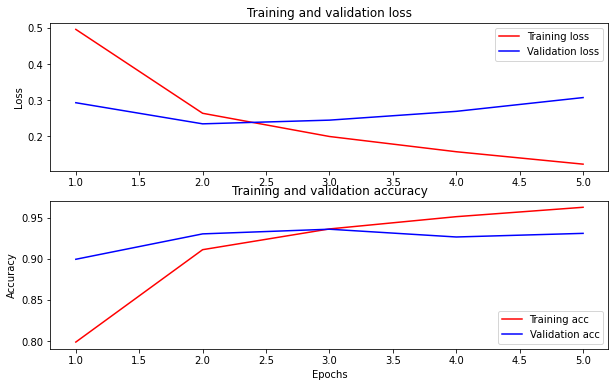

In [38]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [31]:
saved_model_path = 'saved_model'

classifier_model.save(saved_model_path, include_optimizer=False)

In [39]:
saved_model_path = 'saved_model'
reloaded_model = tf.saved_model.load(saved_model_path)

In [40]:
preds = tf.math.argmax(reloaded_model(tf.constant(val_sentences)), axis=1)
calculate_result(val_labels_encoded, preds)

{'accuracy': 0.934301958307012,
 'precision': 0.9318176859977401,
 'recall': 0.934301958307012,
 'f1-score': 0.9327259554542228}

In [41]:
def plot_cm(cm):
  plt.figure(figsize=(9,6))
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

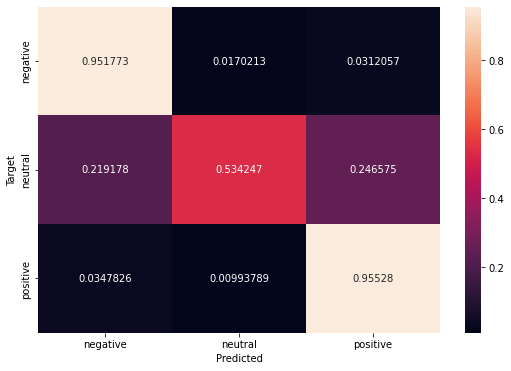

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_labels_encoded, preds, normalize='true')
plot_cm(cm)

In [44]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30}\nscore: {class_names[results[i]]}\n'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

reloaded_results = tf.math.argmax(reloaded_model(tf.constant(val_sentences[:30])), axis=1)

print('Results from the saved model:')
print_my_examples(val_sentences[:30], reloaded_results)

Results from the saved model:
input: giáo_trình chưa cụ_thể        
score: negative

input: giảng buồn_ngủ                
score: negative

input: giáo_viên vui_tính tận_tâm    
score: positive

input: giảng_viên nên giao bài_tập nhiều hơn chia nhóm để làm bài_tập giảng kỹ những vấn_đề trọng_tâm của môn_học đưa ra phương_pháp để học_hiệu quả hơn
score: negative

input: giảng_viên cần giảng bài chi_tiết hơn đi_sâu hơn code và chạy thử chương_trình có trong bài giảng nếu được
score: negative

input: nên có giảng_viên nước_ngoài dạy để sinh_viên có cơ_hội thực_hành giao_tiếp
score: negative

input: nên có bài_tập lớn đồ_án môn_học
score: negative

input: giảng_viên đảm_bảo nội_dung học phân_tích giải nhiều bài_tập
score: positive

input: nêu rõ mục_tiêu mục_đích môn_học để sinh_viên tiếp_thu dễ_dàng
score: negative

input: có một_số vấn_đề nói chưa rõ  
score: negative

input: giáo_viên tận_tình chuẩn_bị bài_học chu_đáo
score: positive

input: giảng_viên dạy hay và tâm_huyết
score: positi